In [1]:
!pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from prophet import Prophet

plt.style.use("seaborn-v0_8")

In [3]:
df = pd.read_csv("~/Desktop/Anomaly detection/Data/Air_Traffic_Passenger_Statistics.csv")

df['date'] = pd.to_datetime(df['Activity Period'], format='%Y%m')

monthly = df.groupby('date')['Passenger Count'].sum().reset_index()
monthly = monthly.rename(columns={'Passenger Count': 'Passengers'})
monthly.head()

,date,Passengers
0,1999-07-01,3976746
1,1999-08-01,3972694
2,1999-09-01,3341964
3,1999-10-01,3468846
4,1999-11-01,3145240


# Exploratory Data Analysis

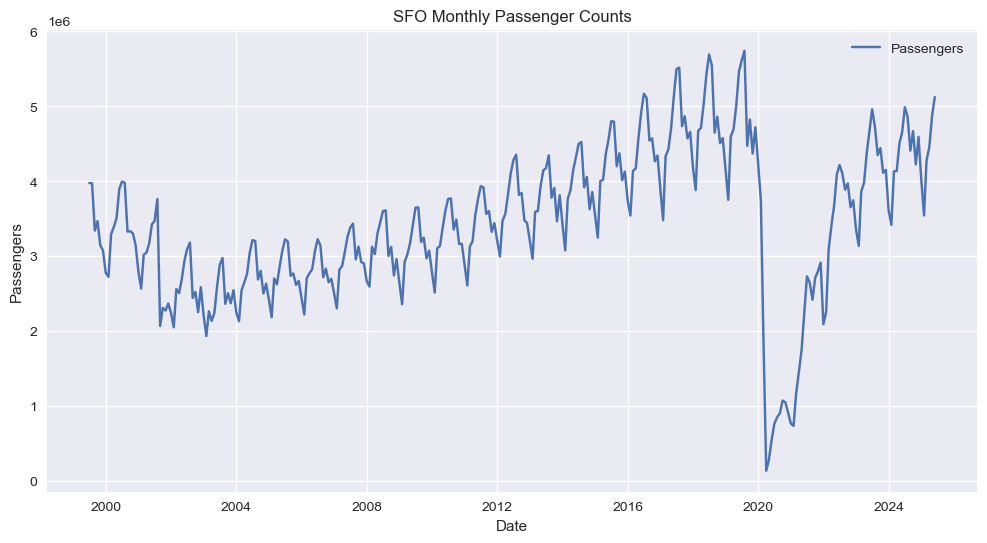

In [5]:
##EDA
plt.figure(figsize=(12,6))
plt.plot(monthly['date'], monthly['Passengers'], label="Passengers")
plt.title("SFO Monthly Passenger Counts")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt. legend()
plt.show()

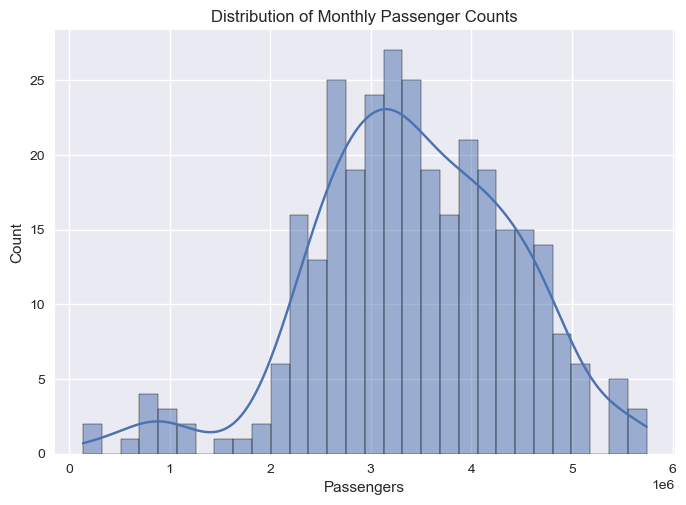

In [6]:
#Histogram of passenger distribution
sns.histplot(monthly['Passengers'], bins=30, kde=True)
plt.title("Distribution of Monthly Passenger Counts")
plt.show()

The line chart of SFO passenger counts (2000-2025) shows strong **seasonality** with recurring peaks in the summer and dips in the winter. There is also a long-term **growth trend** up until early 2020, when the series experiences a sudden and unprecedented collapse due to COVID-19. This drop is an obvious anomaly relative to the overall trend. 

The histogram highlights the skewed distribution with the rare extreme values.

- Normal counts: 2.5M - 4.5M
- Anomalies:<1.5M (2020 pandemic)

### Simple Moving Average (SMA)

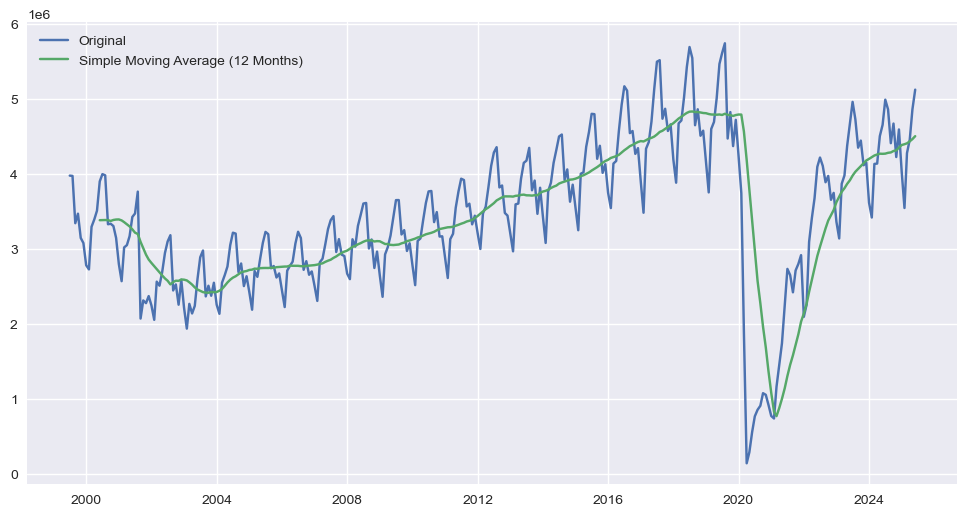

In [9]:
#Simple Moving Average (SMA)
monthly['SMA_12'] = monthly['Passengers'].rolling(window=12).mean()
monthly = monthly[monthly['date'] >= '1998-01-01']

plt.figure(figsize = (12,6))
plt.plot(monthly['date'], monthly['Passengers'], label = "Original")
plt.plot(monthly['date'], monthly['SMA_12'], label="Simple Moving Average (12 Months)")
plt.legend()
plt.show()

The 12-month SMA smooths the passenger data by averaging value over the previous year.
This removes short-term noise while highlighting long-term trends and seasonal cycles.

- The SMA curve clearly shows the steady growth in SFO passenger traffic before 2020.
- The sharp drop during the COVID-19 pandemic falls far below the moving average, marking it as an obvious anomaly.
- By comparing the raw data to the SMA, we can identify months where passenger traffic deviated significantly from historical trends.

### Exponential Moving Average (EMA)

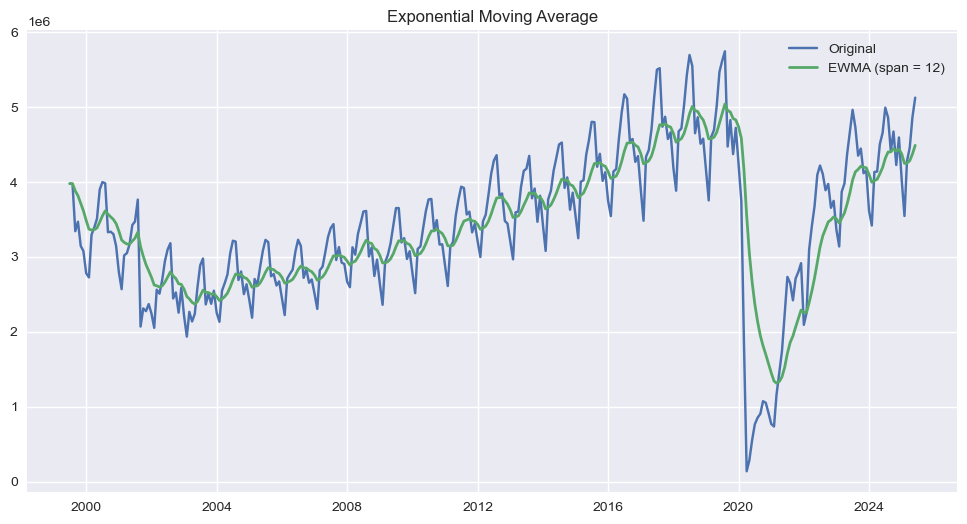

In [12]:
###Exponential Moving Average (EMA)

monthly['EWMA_12'] = monthly['Passengers'].ewm(span = 12, adjust = False).mean()

plt.figure(figsize = (12,6))
plt.plot(monthly['date'], monthly['Passengers'], label = "Original")
plt.plot(monthly['date'], monthly['EWMA_12'], label = "EWMA (span = 12)", linewidth = 2)
plt.title("Exponential Moving Average")
plt.legend()
plt.show()

The 12-month EWA smooths the data but gives more weight to recent values. This makes it more responsive to sudden changes compared to the SMA.

- The EMA line follows the passenger trend more closely than the SMA.
- During the Covid-19 collapse in 2020, the EMA adjusts quickly downward, capturing the anomaly earlier.
- Compared to SMA, which smooths changes more slowly, EMA is better at highlighting recent anomalies while still reducing random noise.

### Statistical Justification 

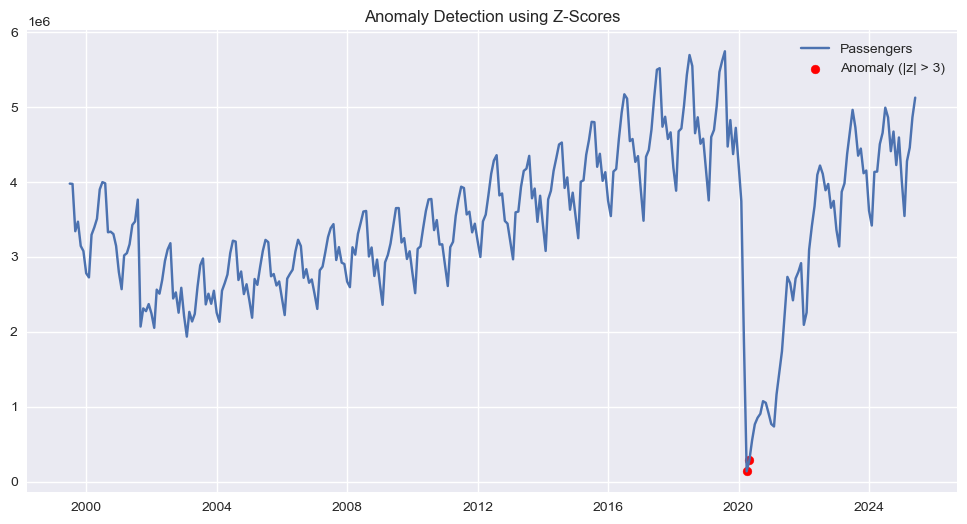

In [15]:
# Z-score Method
monthly['zscore'] = zscore(monthly['Passengers'])
monthly['anomaly_z'] = monthly['zscore'].apply(lambda x: 'Anomaly' if abs(x) > 3 else 'Normal')

plt.figure(figsize = (12,6))
plt.plot(monthly['date'], monthly['Passengers'], label = "Passengers")
plt.scatter(
    monthly.loc[monthly['anomaly_z'] == 'Anomaly', 'date'],
    monthly.loc[monthly['anomaly_z'] == 'Anomaly', 'Passengers'],
    color = 'red', label = 'Anomaly (|z| > 3)', s = 40
)
plt.title("Anomaly Detection using Z-Scores")
plt.legend()
plt.show()

The z-score method standardizes passenger counts relative to the mean and standard deviation.
Any observation with |z| > 3 is flagged as an anomaly.

- In this dataset, the sharp decline in 2020 is indentified as an anomaly (red points).
- This confirms statistically what was already visible in the time-series plot: COVID-19 caused extreme deviation from normal passenger levels.
- Z-scores provide a quantitative threshold for anomaly detection, ensuring that anomalies are not only visually apparent but also statistically significant.

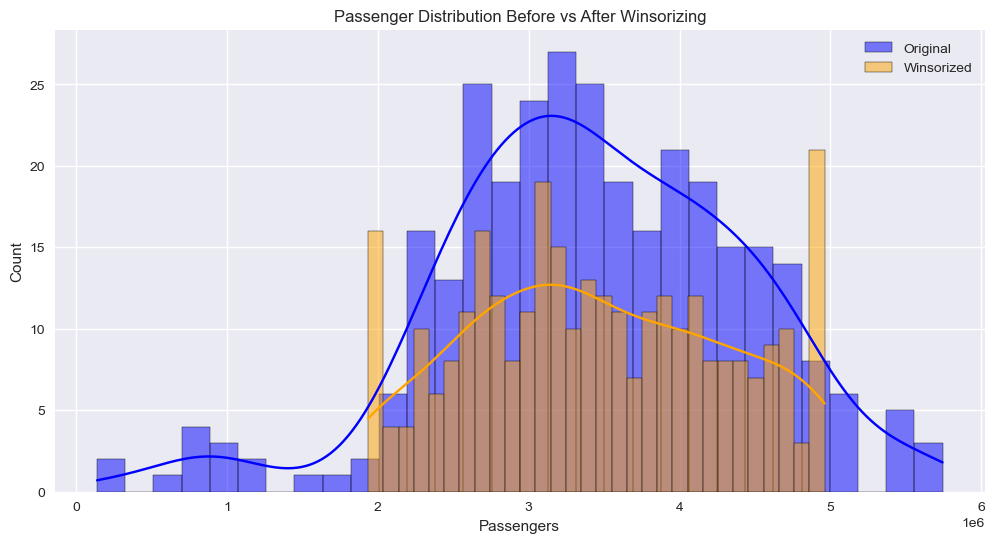

In [17]:
#Winsorizing Method
winsorized = winsorize(monthly['Passengers'], limits = [0.05, 0.05])

plt.figure(figsize = (12,6))
sns.histplot(monthly['Passengers'], bins = 30, kde = True, label = 'Original', color = 'blue', alpha = 0.5)
sns.histplot(winsorized, bins = 30, kde = True, label = 'Winsorized', color = 'orange', alpha = 0.5)
plt.title("Passenger Distribution Before vs After Winsorizing")
plt.legend()
plt.show()

Winsorizing caps the extreme tails of the distribution to reduce the influence of outliers.
Here, I limited the top and bottom 5% of passenger counts.

- The original distribution (blue) is skewed by rare extreme values (such as the COVID-19 collapse).
- The winsorized distribution (orange) smooths out these extremes, showing a more typical range of passenger traffic.
- By comparing the two, we can clearly see how anomalies distory the overall distribution of the data. 

### Prophet - Trend & Seasonality Decomposition

19:18:52 - cmdstanpy - INFO - Chain [1] start processing
19:18:52 - cmdstanpy - INFO - Chain [1] done processing


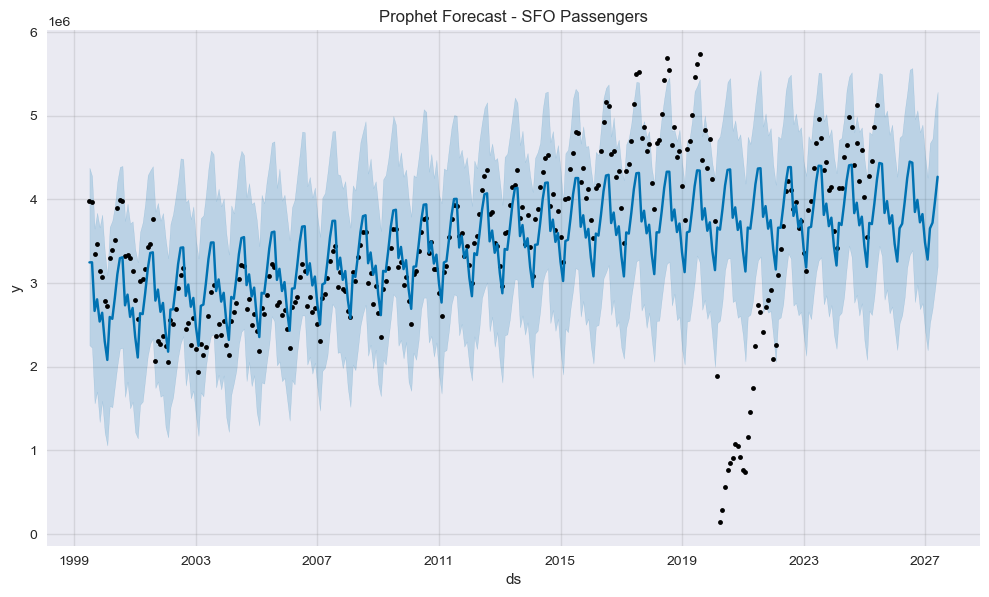

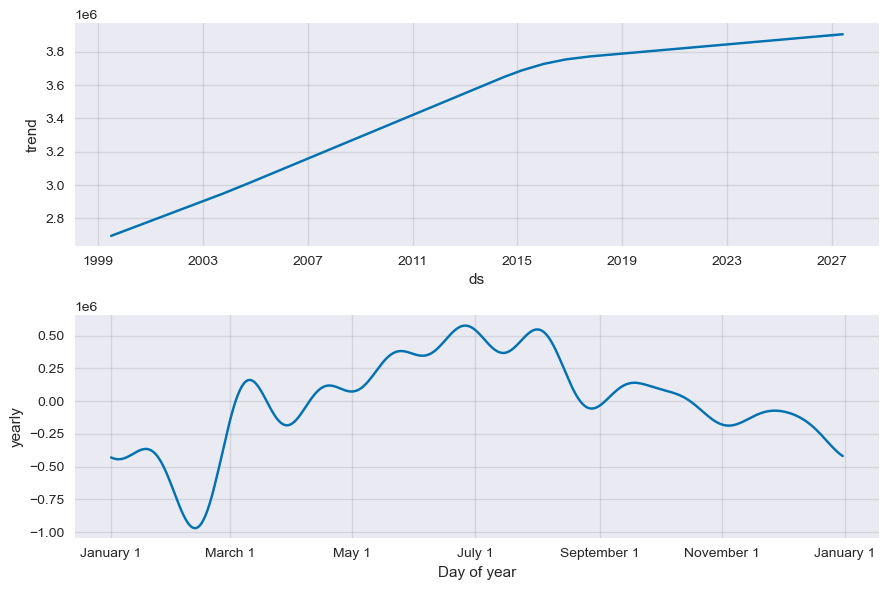

In [20]:
df_prophet = monthly.rename(columns = {'date': 'ds', 'Passengers': 'y'})

m = Prophet(yearly_seasonality = True)
m.fit(df_prophet)

future = m.make_future_dataframe(periods = 24, freq = 'ME')
forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.title("Prophet Forecast - SFO Passengers")
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

The prophet forecast captures the long-term **upward trend** in SFO passenger traffic, as well as the strong **yearly seasonality**.
- The forecast shows steady growth until 2019, followed by a flattening trend.
- Seasonality indicates clear peaks in July to August, when lots of summer travel occur, and dips in January to February (winter off-season). 

The model performs well in capturing regular patterns, but the sharp collapse in 2020 due to COVID-19 is not well explained by the forecast.
This highlights that Prophet assumes historical patterns will repeat, and sudden anomalies appear as large residuals.

By separating **trend**, **seasonality**, and **resideuals**, Prophet helps isolate anomalies like COVID-19 that cannot be explained by normal seasonal fluctuations.

### Prophet with Custom Anomaly (Holiday)

19:18:53 - cmdstanpy - INFO - Chain [1] start processing
19:18:53 - cmdstanpy - INFO - Chain [1] done processing


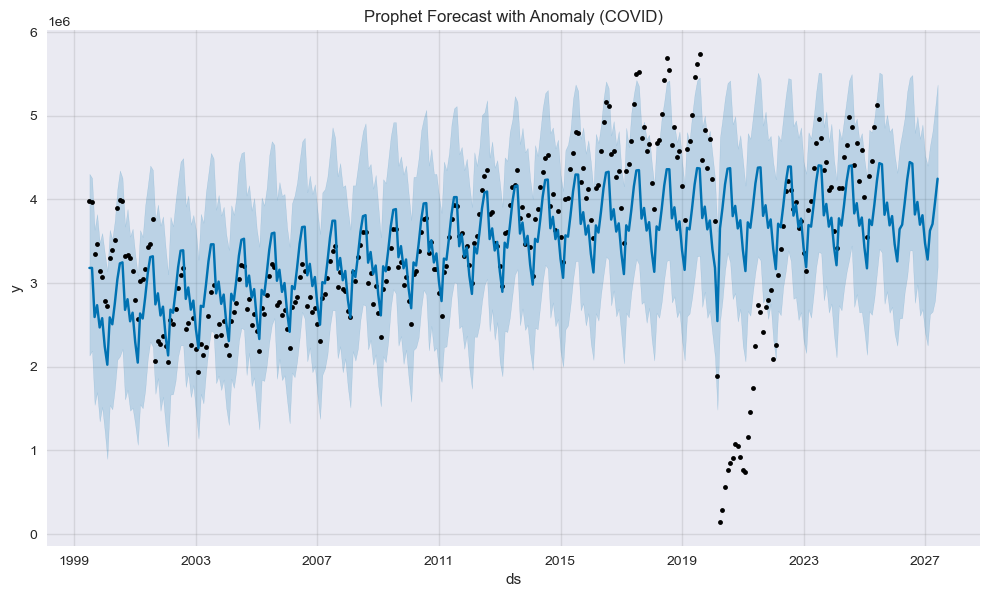

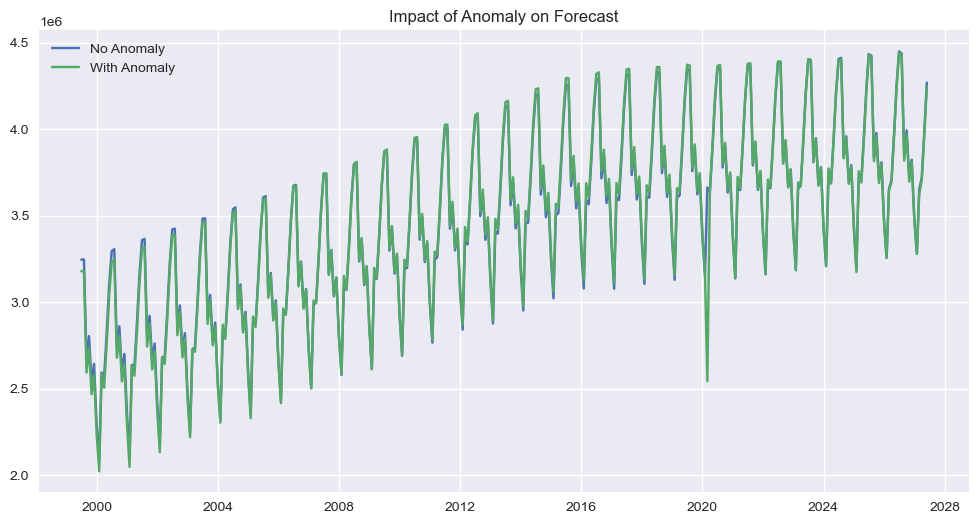

In [23]:
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-01']),
    'lower_window': 0,
    'upper_window': 12
})

m_anom = Prophet(yearly_seasonality = True, holidays = holidays)
m_anom.fit(df_prophet)

future = m_anom.make_future_dataframe(periods=24, freq = 'ME')
forecast_anom = m_anom.predict(future)

fig3 = m_anom.plot(forecast_anom)
plt.title("Prophet Forecast with Anomaly (COVID)")
plt.show()

plt.figure(figsize = (12,6))
plt.plot(forecast['ds'], forecast['yhat'], label = 'No Anomaly')
plt.plot(forecast_anom['ds'], forecast_anom['yhat'], label = 'With Anomaly')
plt.title ("Impact of Anomaly on Forecast")
plt.legend()
plt.show()

By modeling COVID-19b as a holiday in Prophet, we explicity capture its effect.
Forecasts with the anomaly show lower predicted passenger counts than forecasts without it.
This demostrates how shocks can shift future expectations if not accounted for. 

### Conclusion

In summary, this analysis applied multiple approaches to detect anomalies in SFO monthly passenger traffic data. The moving average methods, SMA and EMA, highlight anomalies as deviations from baseline trends. Statistical methods, including Z-scores and winsorizing, provide statistical confirmation, showing that the pandemic period fell far outside the normal distribution of passenger counts. Prophet further separated trend and seasonality, isolating anomalies like COVID-19, and modeling the event as a holiday demonstrated its long-term impact on forecasts. Together, these methods offer a comprehensive framework for detecting and interpreting anomalies in time-series data. 